**Name:** Kamarajugadda Jyothi Phani Vaibhav

**PNR:** 240860825003



**Problem Statement:**

In the field of healthcare, particularly in ophthalmology, early diagnosis of eye diseases is crucial for effective treatment and prevention of blindness. This project focuses on developing a deep learning model that can automatically classify different types of ocular diseases from fundus images (photographs of the back of the eye). The goal is to create a predictive model that can detect multiple eye conditions, such as diabetes, glaucoma, cataracts, hypertension, age-related macular degeneration (AMD), and more, based on features extracted from these images. Given a large dataset of ocular images and diagnostic keywords like ODIR-5K, the model, like Swin Transformer, should accurately classify and predict whether a given eye image is associated with any of these diseases, helping doctors and healthcare professionals with faster and more accurate diagnoses.



**Objective:**

To develop a Deep Learning model to classify the Ocular disease type, using the Microsoft Swin Transformer on the ODIR-5K dataset and predict Glaucoma.

# Importing Required Modules

In [1]:
# For Dataset Download
import kagglehub

# Data Processing
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NTLK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import SnowballStemmer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Deep Learning
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import SwinForImageClassification

# Miscellaneous
import os
import itertools
import string
import re
from random import sample
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


# Loading Dataset

In [3]:
path = kagglehub.dataset_download("andrewmvd/ocular-disease-recognition-odir5k")

print("Path to dataset files:", path)

100%|██████████| 1.62G/1.62G [00:15<00:00, 112MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2


# Exploratory Data Analysis

In [4]:
import os

def get_folder_info(parent_dir):
    folder_info = []

    for dirpath, dirnames, filenames in os.walk(parent_dir):
        total_size = 0
        num_folders = len(dirnames)
        num_files = len(filenames)

        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            total_size += os.path.getsize(filepath)

        if num_files == 1:
            single_file_size = os.path.getsize(os.path.join(dirpath, filenames[0]))
            folder_info.append({
                'folder_name': dirpath,
                'num_folders': num_folders,
                'num_files': num_files,
                'total_size': single_file_size,
                'filenames': filenames[0]
            })
        else:
            folder_info.append({
                'folder_name': dirpath,
                'num_folders': num_folders,
                'num_files': num_files,
                'total_size': total_size,
                'filenames': "Image Files"
            })

    return folder_info

folders = get_folder_info(path)

for folder in folders:
    print(f"Folder: {folder['folder_name']}")
    print(f"Number of subfolders: {folder['num_folders']}")
    print(f"Number of files: {folder['num_files']}")
    print(f"Total size: {folder['total_size']} bytes")
    print('=' * 40)

    if folder['num_files'] == 1:
        single_file = folder['filenames']
        single_file_path = os.path.join(folder['folder_name'], single_file)
        print(f"Single file: {single_file}")
        print(f"Total size: {folder['total_size']} bytes")
        print(f"File path: {single_file_path}")
        print('-' * 40)

Folder: /root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2
Number of subfolders: 2
Number of files: 1
Total size: 1494762 bytes
Single file: full_df.csv
Total size: 1494762 bytes
File path: /root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2/full_df.csv
----------------------------------------
Folder: /root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2/ODIR-5K
Number of subfolders: 1
Number of files: 0
Total size: 0 bytes
Folder: /root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2/ODIR-5K/ODIR-5K
Number of subfolders: 2
Number of files: 1
Total size: 268198 bytes
Single file: data.xlsx
Total size: 268198 bytes
File path: /root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2/ODIR-5K/ODIR-5K/data.xlsx
----------------------------------------
Folder: /root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition

In [5]:
eyes = pd.read_csv(path + '/full_df.csv')
eyes

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4686_left.jpg
6388,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4688_left.jpg
6389,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4689_left.jpg
6390,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4690_left.jpg


In [6]:
eyes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [7]:
eyes.describe(include="all")

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
count,6392.000000,6392.000000,6392,6392,6392,6392,6392,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392,6392,6392,6392
unique,NaN,NaN,2,3358,3358,196,205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6392,8,8,6392
top,NaN,NaN,Male,0_left.jpg,0_right.jpg,normal fundus,normal fundus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
freq,NaN,NaN,3424,2,2,2796,2705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2873,2873,1
mean,2271.150814,57.857947,NaN,NaN,NaN,NaN,NaN,0.328692,0.332134,0.062109,0.062891,0.049906,0.031758,0.047872,0.248436,NaN,NaN,NaN,NaN
std,1417.559018,11.727737,NaN,NaN,NaN,NaN,NaN,0.469775,0.471016,0.241372,0.242786,0.217768,0.175370,0.213513,0.432139,NaN,NaN,NaN,NaN
min,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,920.750000,51.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
50%,2419.500000,59.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
75%,3294.000000,66.000000,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN


In [8]:
eyes.columns

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')

In [9]:
len(eyes)

6392

In [10]:
len(eyes[eyes.duplicated()])

0

In [11]:
eyes.isnull().sum()

,0
ID,0
Patient Age,0
Patient Sex,0
Left-Fundus,0
Right-Fundus,0
Left-Diagnostic Keywords,0
Right-Diagnostic Keywords,0
N,0
D,0
G,0


In [12]:
label_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
label_names = [
    "Normal",
    "Diabetic Retinopathy",
    "Glaucoma",
    "Cataract",
    "Age-related Macular Degeneration",
    "Hypertension",
    "Myopia",
    "Other diseases"
]

labels_dic = dict(zip(label_columns, label_names))
print(labels_dic)

{'N': 'Normal', 'D': 'Diabetic Retinopathy', 'G': 'Glaucoma', 'C': 'Cataract', 'A': 'Age-related Macular Degeneration', 'H': 'Hypertension', 'M': 'Myopia', 'O': 'Other diseases'}


In [13]:
print("Count of rows containing 'right':", eyes['filename'].str.contains('right').sum())
print("Count of rows containing 'left':", eyes['filename'].str.contains('left').sum())

Count of rows containing 'right': 3194
Count of rows containing 'left': 3198


# Data Cleaning

In [14]:
eyes['Left-Fundus'].nunique()

3358

In [15]:
photo_counts = eyes['Left-Fundus'].value_counts()
photo_more_than_once = photo_counts[photo_counts > 1].index.tolist()
print(len(photo_more_than_once))

3034


In [16]:
photo_more_than_once[0]

'0_left.jpg'

In [17]:
eyes[eyes['Left-Fundus'] == '0_left.jpg']

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
3194,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",0_left.jpg


In [18]:
print(len(eyes[(eyes['labels'] == "['N']") & (eyes['N'] != 1)]))
print(len(eyes[(eyes['labels'] == "['D']") & (eyes['D'] != 1)]))
print(len(eyes[(eyes['labels'] == "['O']") & (eyes['O'] != 1)]))
print(len(eyes[(eyes['labels'] == "['C']") & (eyes['C'] != 1)]))
print(len(eyes[(eyes['labels'] == "['G']") & (eyes['G'] != 1)]))
print(len(eyes[(eyes['labels'] == "['A']") & (eyes['A'] != 1)]))
print(len(eyes[(eyes['labels'] == "['M']") & (eyes['M'] != 1)]))
print(len(eyes[(eyes['labels'] == "['H']") & (eyes['H'] != 1)]))

772
0
3
0
0
0
0
0


In [19]:
eyes.drop(columns=[ 'ID'] , inplace=True)

In [20]:
old_path_part = "../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/"
new_path_part = path + "/ODIR-5K/ODIR-5K/Training Images/"
eyes['filepath'] = eyes['filepath'].replace(old_path_part, new_path_part, regex=True)

In [21]:
for filepath in eyes['filepath']:
    assert os.path.exists(filepath), f"Missing file: {filepath}"

In [22]:
len(eyes[eyes['Patient Age'] == 1])

28

In [23]:
eyes['labels'] = eyes['labels'].str[2]
eyes.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [24]:
eyes['labels'].nunique()

8

In [25]:
eyes['labels'].value_counts()

,count
labels,
N,2873
D,1608
O,708
C,293
G,284
A,266
M,232
H,128


# Data Visualization

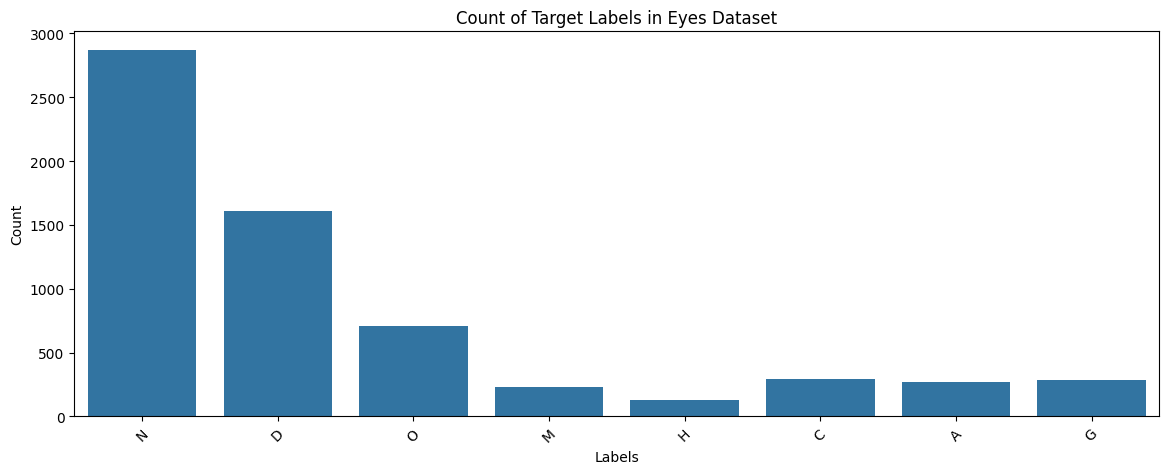

In [26]:
plt.figure(figsize=(14, 5))
sns.countplot(x='labels', data=eyes , orient='h')
plt.title('Count of Target Labels in Eyes Dataset')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [27]:
eyes[eyes['Left-Diagnostic Keywords'] == 'low image quality']

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
2547,45,Male,3935_left.jpg,3935_right.jpg,low image quality,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",3935_right.jpg
2606,71,Male,4007_left.jpg,4007_right.jpg,low image quality,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4007_right.jpg
2744,48,Male,4169_left.jpg,4169_right.jpg,low image quality,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4169_right.jpg
2854,51,Male,4290_left.jpg,4290_right.jpg,low image quality,normal fundus,1,0,0,0,0,0,0,0,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",4290_right.jpg
2989,62,Female,4442_left.jpg,4442_right.jpg,low image quality,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4442_right.jpg
2994,50,Male,4448_left.jpg,4448_right.jpg,low image quality,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4448_right.jpg
3053,67,Male,4522_left.jpg,4522_right.jpg,low image quality,severe nonproliferative retinopathy,0,1,0,0,0,0,0,0,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4522_right.jpg


In [28]:
eyes = eyes.loc[~(eyes['Left-Diagnostic Keywords'] == 'low image quality')]

In [29]:
print(len(eyes[(eyes['labels'] == "['N']") & (eyes['N'] != 1)]))
print(len(eyes[(eyes['labels'] == "['O']") & (eyes['O'] != 1)]))
eyes.head()

0
0


,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [30]:
photos_unique = eyes.drop_duplicates(subset='Left-Fundus', keep='first')
eyes = photos_unique
eyes.reset_index(drop=True,inplace=True)
len(eyes)

3351

In [31]:
eyes['Left-Diagnostic Keywords'].nunique()

195

In [32]:
eyes['Right-Diagnostic Keywords'].nunique()

205

In [33]:
eyes['Left-Diagnostic Keywords'].mode()

,Left-Diagnostic Keywords
0,normal fundus


In [34]:
eyes['Left-Diagnostic Keywords'].value_counts()

,count
Left-Diagnostic Keywords,
normal fundus,1433
moderate non proliferative retinopathy,366
mild nonproliferative retinopathy,220
cataract,135
pathological myopia,111
...,...
drusen，cataract，lens dust,1
optic disk epiretinal membrane,1
pigment epithelium proliferation,1


In [35]:
eyes['Right-Diagnostic Keywords'].mode()

,Right-Diagnostic Keywords
0,normal fundus


In [36]:
both_eyes_normal = eyes[
    (eyes['Right-Diagnostic Keywords'] == 'normal fundus') &
    (eyes['Left-Diagnostic Keywords'] == 'normal fundus')
]

both_eyes_normal.reset_index(inplace=True,drop=True)

len(both_eyes_normal)

1001

In [37]:
both_eyes_not_normal = eyes[
    (eyes['Right-Diagnostic Keywords'] != 'normal fundus') &
    (eyes['Left-Diagnostic Keywords'] != 'normal fundus')
]

both_eyes_not_normal.reset_index(inplace=True,drop=True)

len(both_eyes_not_normal)

1537

In [38]:
right_eye_normal = eyes[
    (eyes['Right-Diagnostic Keywords'] == 'normal fundus') &
    (eyes['Left-Diagnostic Keywords'] != 'normal fundus')
]

right_eye_normal.reset_index(inplace=True,drop=True)

len(right_eye_normal)

381

In [39]:
left_eye_normal = eyes[
    (eyes['Right-Diagnostic Keywords'] != 'normal fundus') &
    (eyes['Left-Diagnostic Keywords'] == 'normal fundus')
]

left_eye_normal.reset_index(inplace=True,drop=True)

len(left_eye_normal)

432

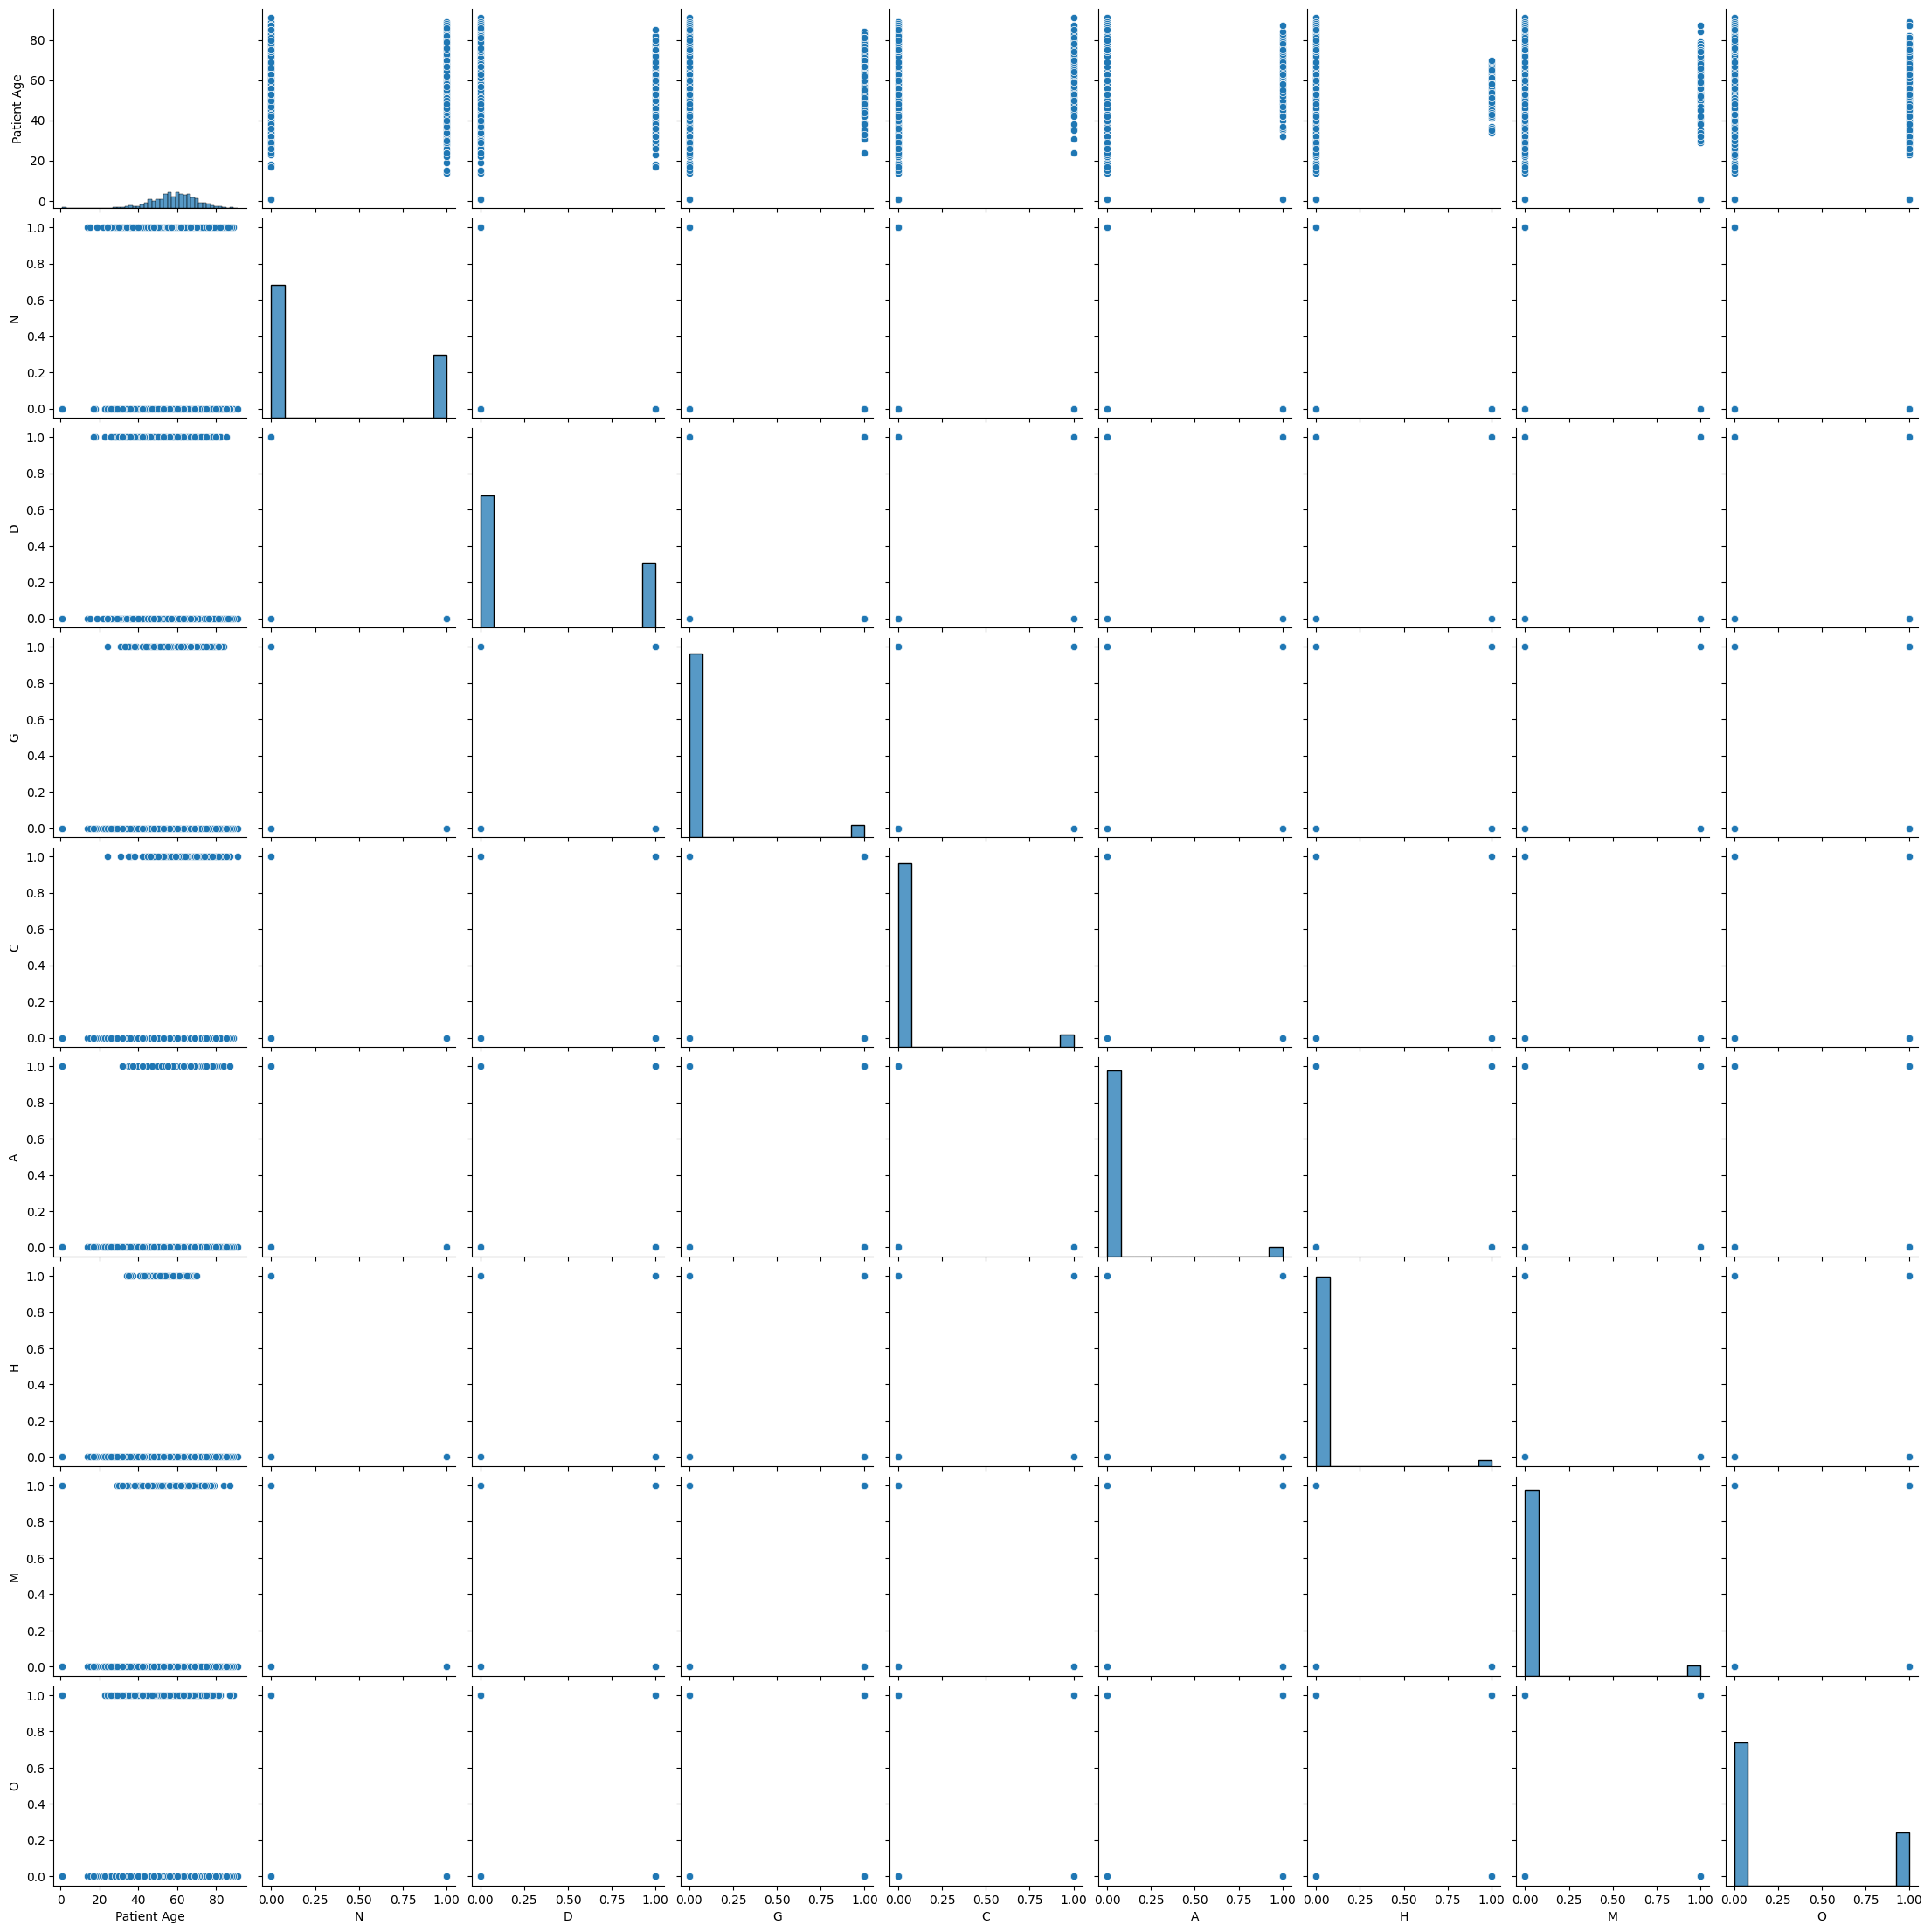

In [40]:
sns.pairplot(eyes)
plt.show()

In [41]:
data_num = eyes[['Patient Age', 'N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']]
data_num.head()

,Patient Age,N,D,G,C,A,H,M,O
0,69,0,0,0,1,0,0,0,0
1,57,1,0,0,0,0,0,0,0
2,42,0,1,0,0,0,0,0,1
3,53,0,1,0,0,0,0,0,1
4,50,0,1,0,0,0,0,0,0


In [42]:
corr_exists = data_num.corr()
corr_exists

,Patient Age,N,D,G,C,A,H,M,O
Patient Age,1.000000,-0.065578,-0.087634,0.102499,0.187126,0.058337,-0.026081,-0.017768,0.064655
N,-0.065578,1.000000,-0.481417,-0.176372,-0.177283,-0.155826,-0.122721,-0.159805,-0.419182
D,-0.087634,-0.481417,1.000000,-0.099397,-0.079602,-0.110683,0.041320,-0.107112,-0.022628
G,0.102499,-0.176372,-0.099397,1.000000,-0.050392,0.005658,0.012007,-0.019828,-0.035353
C,0.187126,-0.177283,-0.079602,-0.050392,1.000000,-0.058169,-0.031480,-0.059655,-0.072911
A,0.058337,-0.155826,-0.110683,0.005658,-0.058169,1.000000,-0.008119,-0.033523,-0.090674
H,-0.026081,-0.122721,0.041320,0.012007,-0.031480,-0.008119,1.000000,-0.041295,-0.061592
M,-0.017768,-0.159805,-0.107112,-0.019828,-0.059655,-0.033523,-0.041295,1.000000,-0.009718
O,0.064655,-0.419182,-0.022628,-0.035353,-0.072911,-0.090674,-0.061592,-0.009718,1.000000


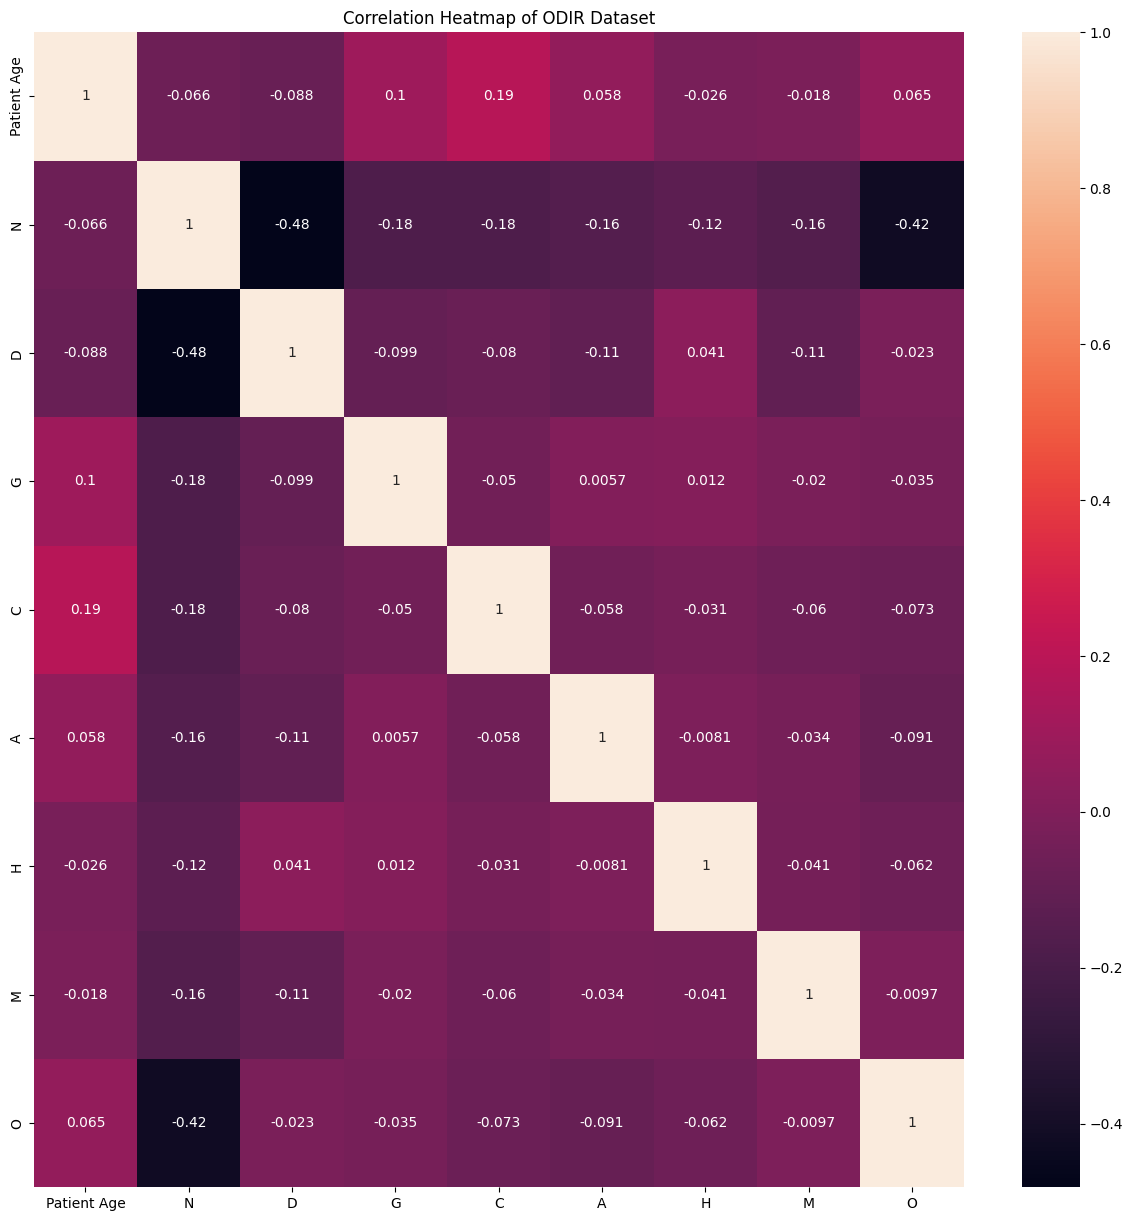

In [43]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_exists, annot=True)
plt.title('Correlation Heatmap of ODIR Dataset')
plt.show()

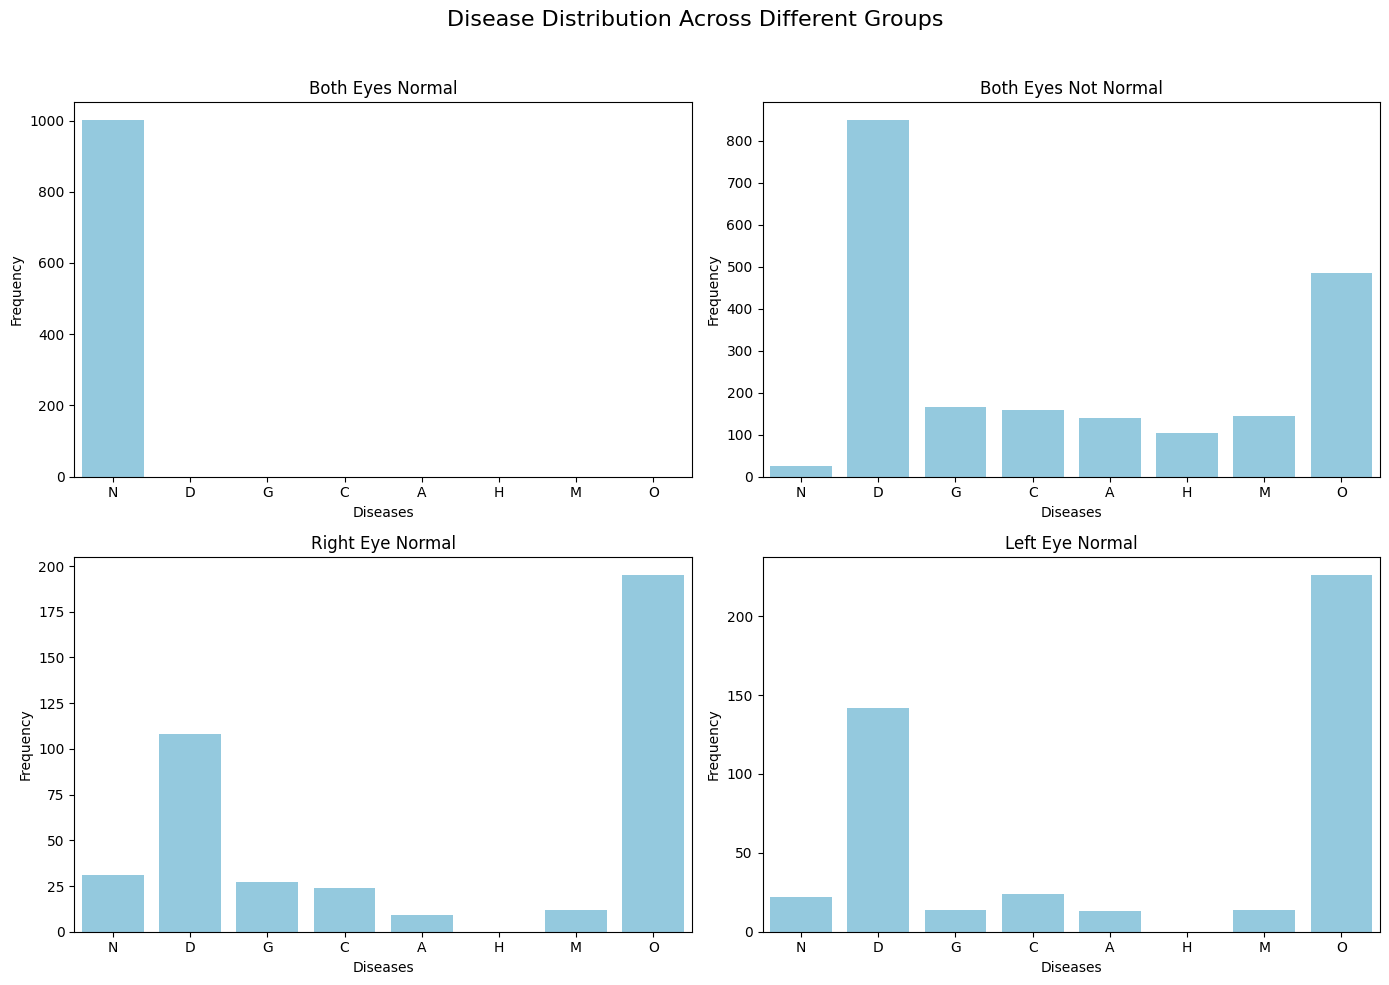

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Disease Distribution Across Different Groups', fontsize=16)

titles = [
    'Both Eyes Normal',
    'Both Eyes Not Normal',
    'Right Eye Normal',
    'Left Eye Normal'
]

dataframes = [both_eyes_normal, both_eyes_not_normal, right_eye_normal, left_eye_normal]

for df, ax, title in zip(dataframes, axes.ravel(), titles):
    disease_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    disease_counts = df[disease_columns].sum()

    sns.barplot(x=disease_counts.index, y=disease_counts.values, color='skyblue', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Diseases')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

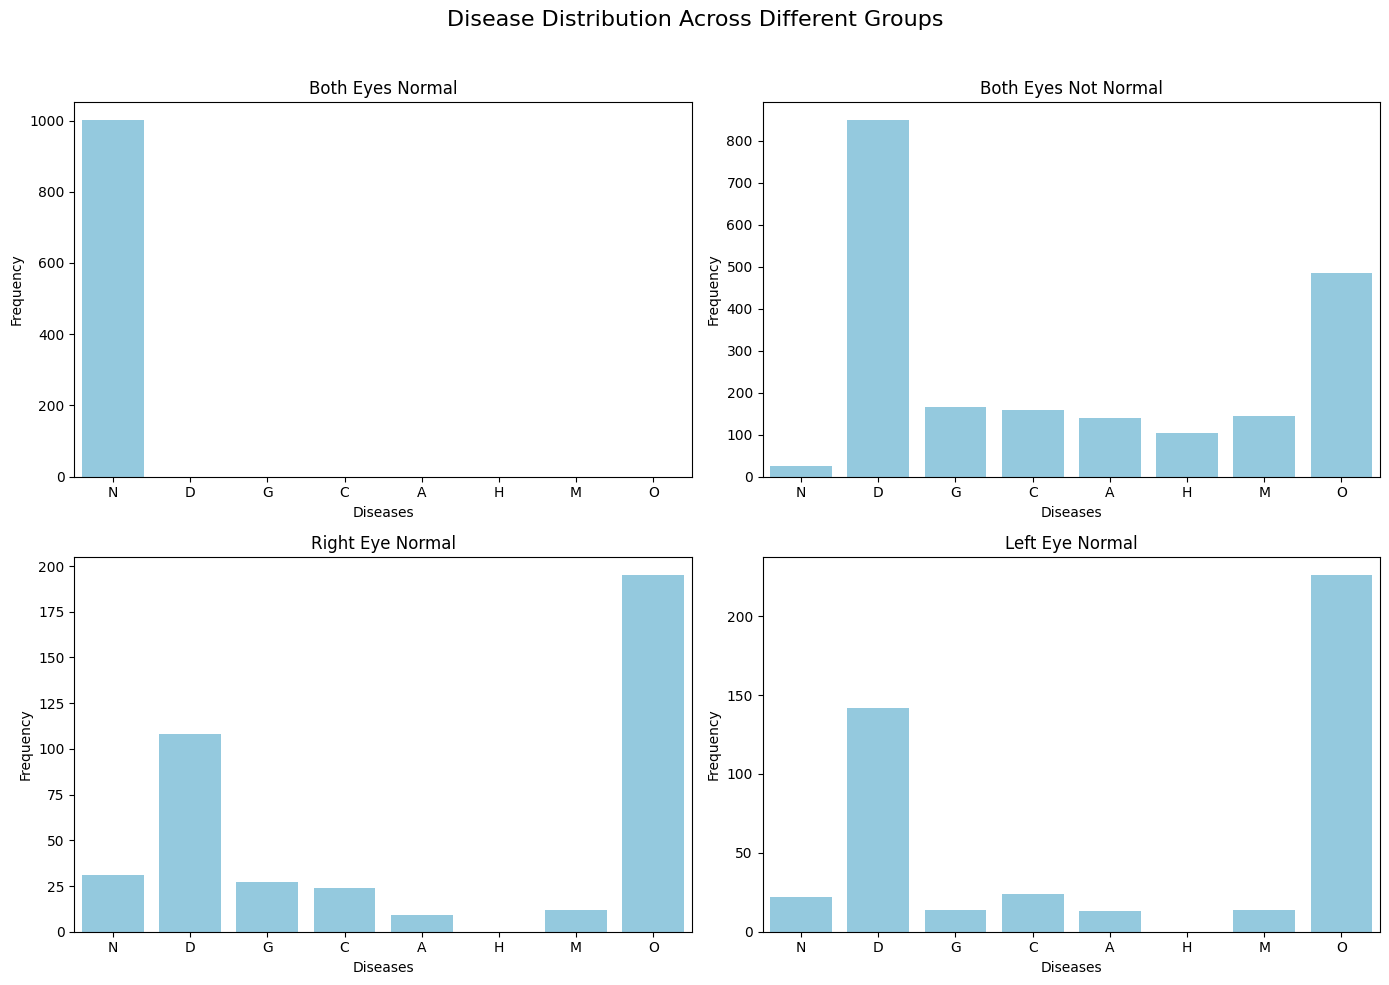

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Disease Distribution Across Different Groups', fontsize=16)

titles = [
    'Both Eyes Normal',
    'Both Eyes Not Normal',
    'Right Eye Normal',
    'Left Eye Normal'
]

dataframes = [both_eyes_normal, both_eyes_not_normal, right_eye_normal, left_eye_normal]

for df, ax, title in zip(dataframes, axes.ravel(), titles):
    disease_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    disease_counts = df[disease_columns].sum()

    sns.barplot(x=disease_counts.index, y=disease_counts.values, color='skyblue', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Diseases')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

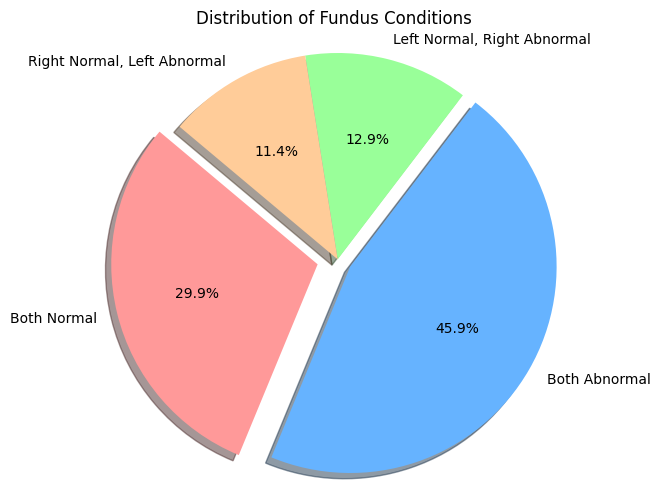

In [46]:
condition_normal_left = eyes['Left-Diagnostic Keywords'] == 'normal fundus'
condition_normal_right = eyes['Right-Diagnostic Keywords'] == 'normal fundus'

both_normal = (condition_normal_left) & (condition_normal_right)
both_abnormal = (~condition_normal_left) & (~condition_normal_right)
left_normal_right_abnormal = (condition_normal_left) & (~condition_normal_right)
right_normal_left_abnormal = (~condition_normal_left) & (condition_normal_right)

counts = {
    'Both Normal': both_normal.sum(),
    'Both Abnormal': both_abnormal.sum(),
    'Left Normal, Right Abnormal': left_normal_right_abnormal.sum(),
    'Right Normal, Left Abnormal': right_normal_left_abnormal.sum()
}

labels = counts.keys()
sizes = counts.values()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
explode = (0.1, 0.07, 0, 0)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Fundus Conditions')
plt.axis('equal')

plt.show()

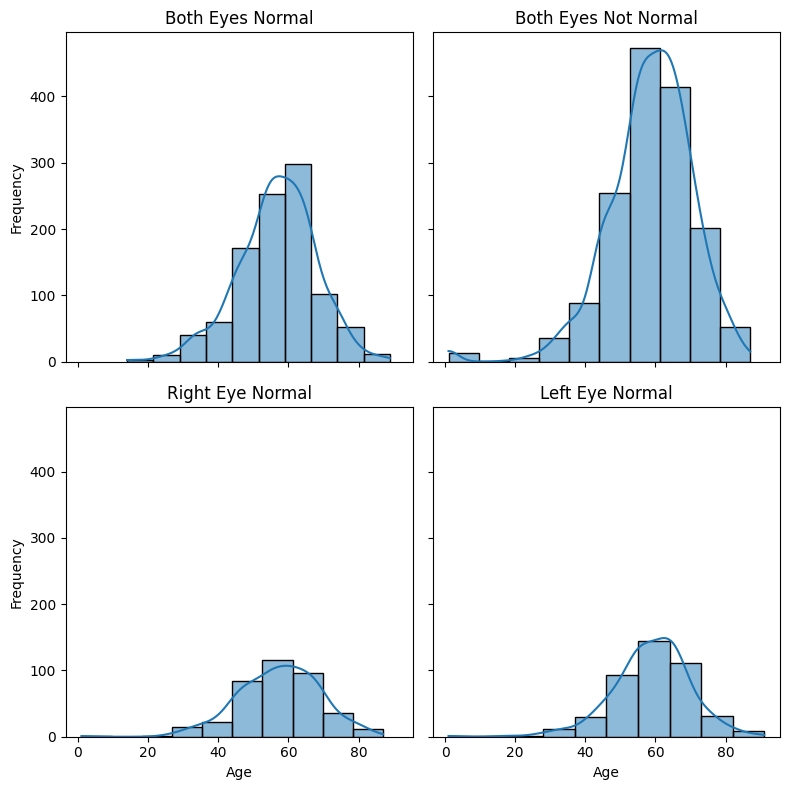

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)

dataframes = [both_eyes_normal, both_eyes_not_normal, right_eye_normal, left_eye_normal]
titles = ['Both Eyes Normal', 'Both Eyes Not Normal', 'Right Eye Normal', 'Left Eye Normal']

for i, (df, title) in enumerate(zip(dataframes, titles)):
    row = i // 2
    col = i % 2
    sns.histplot(df['Patient Age'], kde=True, bins=10, ax=axes[row, col])
    axes[row, col].set_title(title)
    axes[row, col].set_xlabel('Age')
    axes[row, col].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

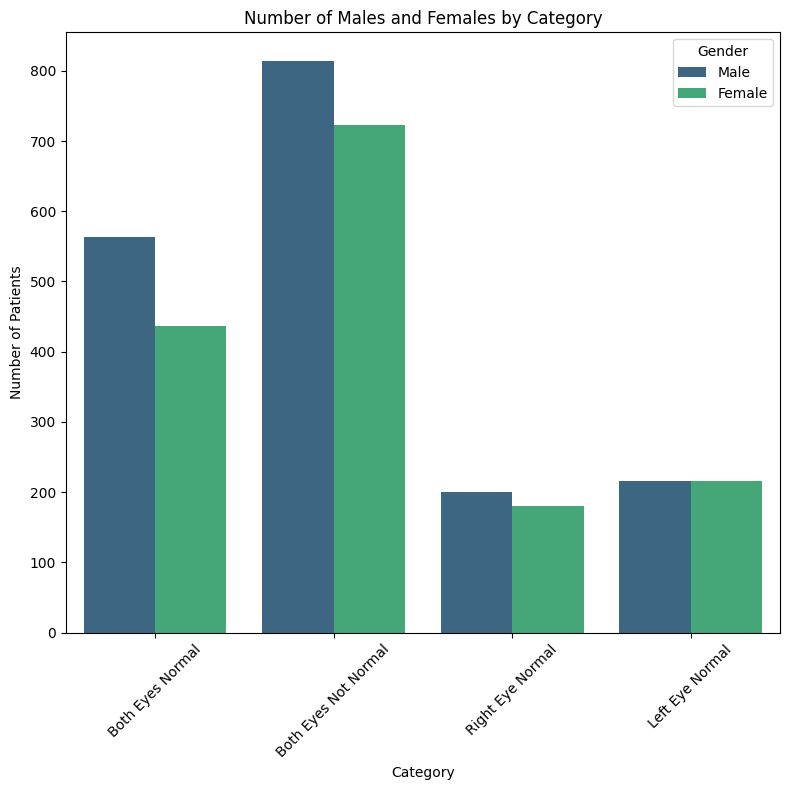

In [48]:
counts = {
    'Both Eyes Normal': both_eyes_normal['Patient Sex'].value_counts(),
    'Both Eyes Not Normal': both_eyes_not_normal['Patient Sex'].value_counts(),
    'Right Eye Normal': right_eye_normal['Patient Sex'].value_counts(),
    'Left Eye Normal': left_eye_normal['Patient Sex'].value_counts()
}

plot_data = pd.DataFrame(counts).fillna(0).T.reset_index()
plot_data = plot_data.melt(id_vars='index', var_name='Gender', value_name='Count')
plot_data = plot_data.rename(columns={'index': 'Category'})

plt.figure(figsize=(8, 8))
sns.barplot(data=plot_data, x='Category', y='Count', hue='Gender', palette='viridis')

plt.title('Number of Males and Females by Category')
plt.xlabel('Category')
plt.ylabel('Number of Patients')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

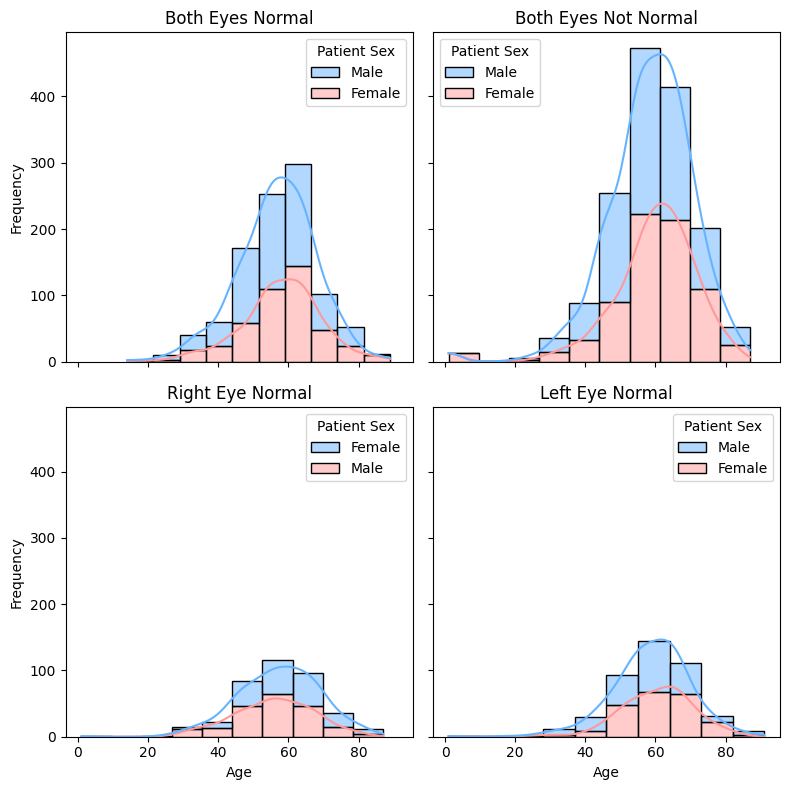

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)

dataframes = [both_eyes_normal, both_eyes_not_normal, right_eye_normal, left_eye_normal]
titles = ['Both Eyes Normal', 'Both Eyes Not Normal', 'Right Eye Normal', 'Left Eye Normal']
colors = ['#66b3ff', '#ff9999']

for i, (df, title) in enumerate(zip(dataframes, titles)):
    row = i // 2
    col = i % 2
    sns.histplot(df, x='Patient Age', hue='Patient Sex', multiple='stack', palette=colors, bins=10, ax=axes[row, col], kde=True)
    axes[row, col].set_title(title)
    axes[row, col].set_xlabel('Age')
    axes[row, col].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

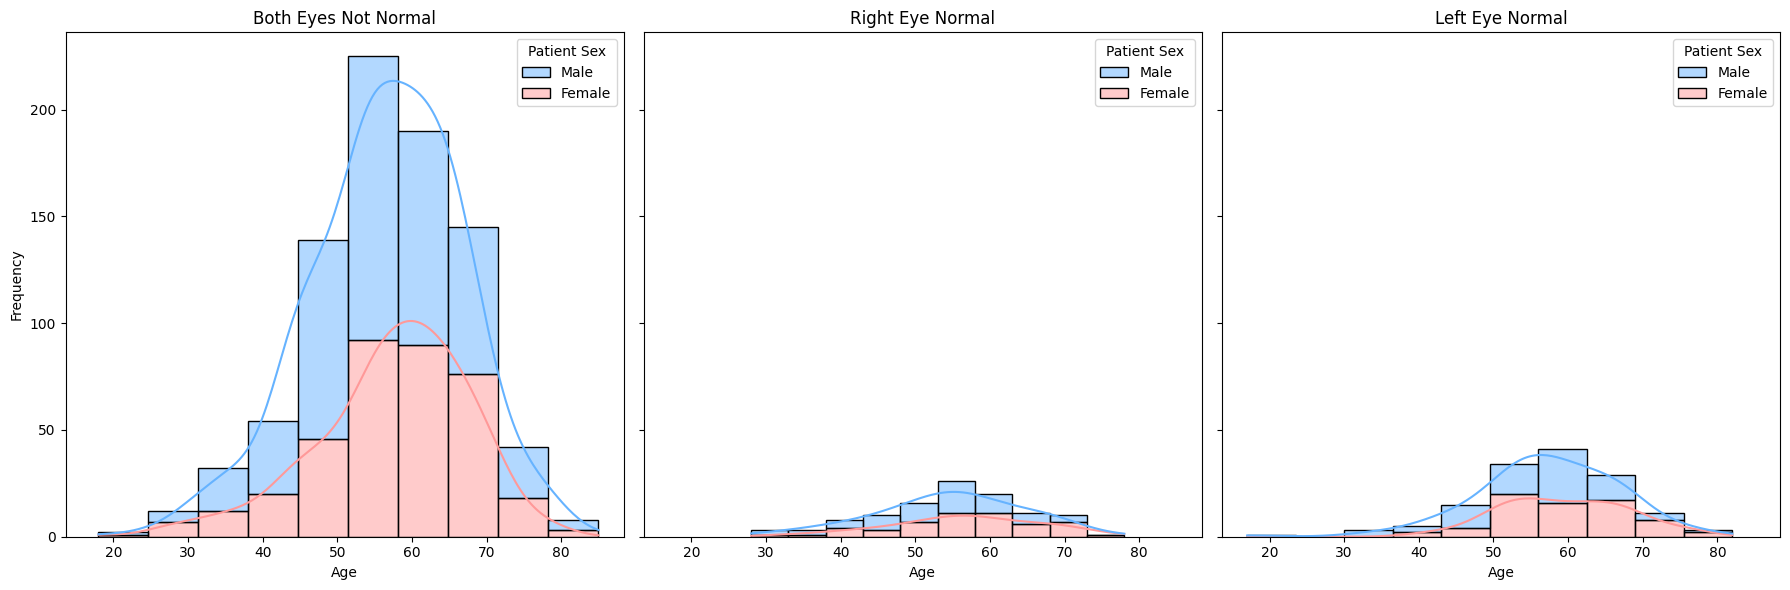

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

dataframes = [both_eyes_not_normal, right_eye_normal, left_eye_normal]

titles = ['Both Eyes Not Normal', 'Right Eye Normal', 'Left Eye Normal']
colors = ['#66b3ff', '#ff9999']

for i, (df, title) in enumerate(zip(dataframes, titles)):
    row = i // 3
    col = i % 3
    filtered_df = df.query('D == 1')
    if not filtered_df.empty:
        sns.histplot(filtered_df, x='Patient Age', hue='Patient Sex', multiple='stack', palette=colors, bins=10, ax=axes[col], kde=True)
    axes[col].set_title(title)
    axes[col].set_xlabel('Age')
    axes[col].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

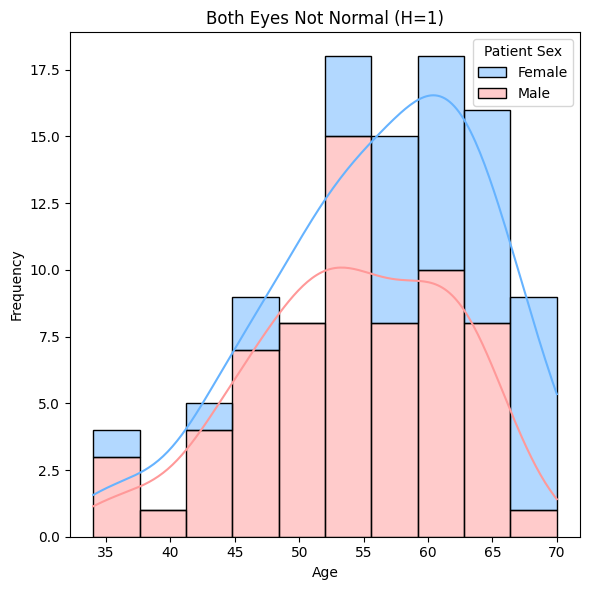

In [51]:
fig, ax = plt.subplots(figsize=(6, 6))

df = both_eyes_not_normal
title = 'Both Eyes Not Normal (H=1)'
colors = ['#66b3ff', '#ff9999']

filtered_df = df.query('H == 1')
if not filtered_df.empty:
    sns.histplot(filtered_df, x='Patient Age', hue='Patient Sex', multiple='stack', palette=colors, bins=10, ax=ax, kde=True)
    ax.set_title(title)
    ax.set_xlabel('Age')
    ax.set_ylabel('Frequency')
else:
    ax.text(0.5, 0.5, 'No data available for H = 1', horizontalalignment='center', verticalalignment='center', fontsize=14, color='red')

plt.tight_layout()
plt.show()

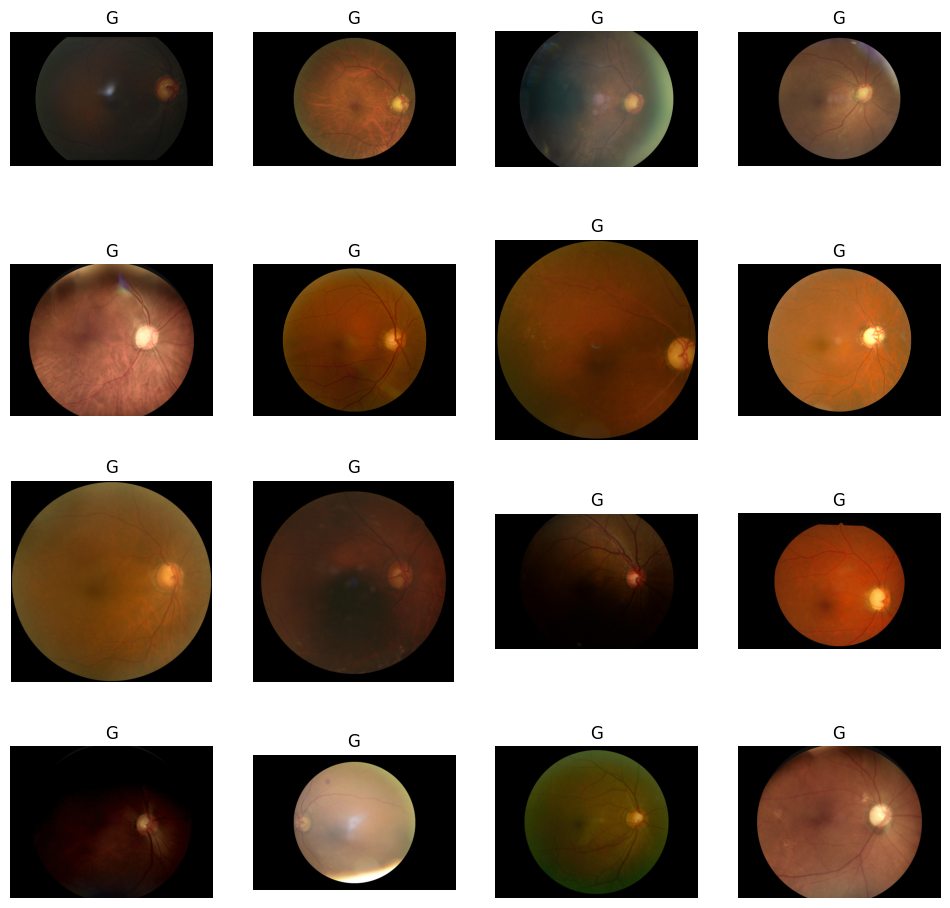

In [52]:
filtered_eyes = eyes[eyes['labels'] == 'G']
sample_images = sample(filtered_eyes['filepath'].tolist(), 16)

plt.figure(figsize=(12, 12))

for i in range(16):
    image = Image.open(sample_images[i])

    label = filtered_eyes.iloc[i]['labels']

    plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(label, color='k', fontsize=12)
    plt.axis("off")

plt.show()

In [53]:
stemmer = SnowballStemmer("english")
stopword = set(stopwords.words('english'))

def clean(text):
    # Convert to string and lower case
    text = str(text).lower()

    # Remove URLs, HTML tags, punctuation, newlines, and numbers
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)

    # Remove stopwords
    text = [word for word in text.split() if word not in stopword]
    text = " ".join(text)

    # Apply stemming
    text = [stemmer.stem(word) for word in text.split()]
    text = " ".join(text)

    return text

# Apply the cleaning function to 'Right-Diagnostic Keywords'
eyes['Right-Diagnostic Keywords'] = eyes['Right-Diagnostic Keywords'].apply(clean)

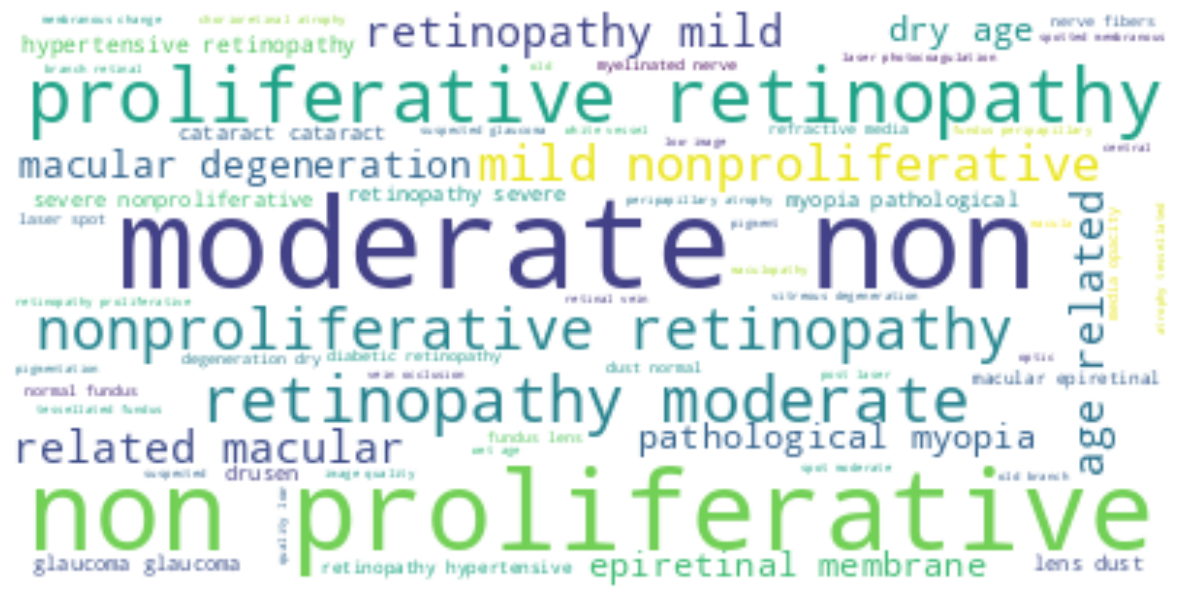

In [54]:
text = " ".join(i for i in both_eyes_not_normal['Right-Diagnostic Keywords'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

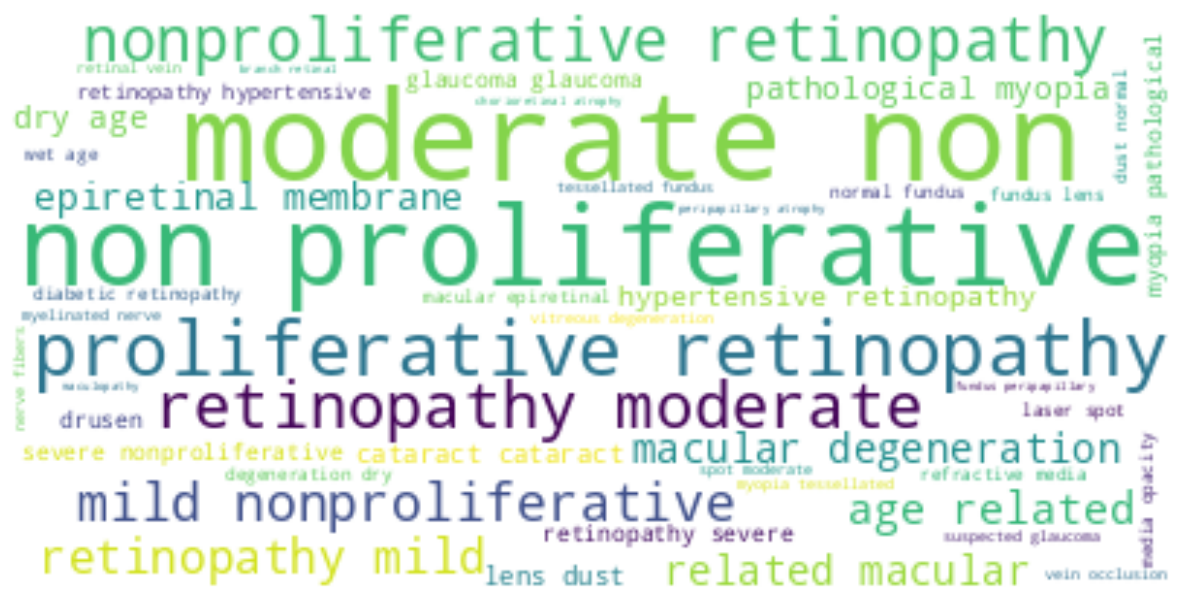

In [55]:
text = " ".join(i for i in both_eyes_not_normal['Left-Diagnostic Keywords'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Model Building

In [56]:
eyes = eyes[['filename', 'filepath', 'labels']]

In [57]:
label_encoder = LabelEncoder()

eyes['labels_encoded'] = label_encoder.fit_transform(eyes['labels'])

for label, encoded_value in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{label}: {encoded_value}")

A: 0
C: 1
D: 2
G: 3
H: 4
M: 5
N: 6
O: 7


In [58]:
eyes.head()

,filename,filepath,labels,labels_encoded
0,0_right.jpg,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,N,6
1,1_right.jpg,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,N,6
2,2_right.jpg,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,D,2
3,4_right.jpg,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,D,2
4,5_right.jpg,/root/.cache/kagglehub/datasets/andrewmvd/ocul...,D,2


In [59]:
train_df, test_df = train_test_split(eyes, test_size=0.2, random_state=42, stratify=eyes['labels_encoded'])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['labels_encoded'])

In [60]:
class ODIRDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepath']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['labels_encoded']

        if self.transform:
            image = self.transform(image)

        return image, label

In [61]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [62]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [63]:
train_dataset = ODIRDataset(train_df, transform=train_transform)
val_dataset = ODIRDataset(val_df, transform=val_transform)
test_dataset = ODIRDataset(test_df, transform=val_transform)

In [64]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Development

In [65]:
'''
class SwinTransformerWithHead(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.fc = nn.Linear(backbone.num_features, num_classes)  # Fully Connected Layer

    def forward(self, x):
        x = self.backbone(x)  # Output shape: [batch_size, num_features, height, width]
        x = self.global_pool(x)  # Output shape: [batch_size, num_features, 1, 1]
        x = x.flatten(1)  # Output shape: [batch_size, num_features]
        x = self.fc(x)  # Output shape: [batch_size, num_classes]
        return x

# Load the Swin Transformer backbone
backbone = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=0)
'''

# Wrap the backbone with the new head
#model = SwinTransformerWithHead(backbone, num_classes=len(label_encoder.classes_))
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=8)

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [67]:
class_weights = compute_class_weight('balanced', classes=np.unique(eyes['labels_encoded']), y=eyes['labels_encoded'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [68]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [69]:
save_dir = '/content/downloadable'
os.makedirs(save_dir, exist_ok=True)

In [70]:
if os.path.exists(os.path.join(save_dir, 'training_history.csv')):
  training_history_df = pd.read_csv(os.path.join(save_dir, 'training_history.csv'))
else:
  #training_history_df = pd.DataFrame(columns=["Epoch", "Train Loss"])
  training_history_df = pd.DataFrame(columns=["Epoch", "Train Loss", "Val Loss", "Val Acc"])

In [71]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)

In [72]:
def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return (val_loss / len(dataloader)), (correct / total)

In [73]:
if os.path.exists(os.path.join(save_dir, 'swin_model_final.pth')):
  model.load_state_dict(torch.load(os.path.join(save_dir, 'swin_model_final.pth')))
  print("Swin Model Found!\nLoading the model!")
else:
  NUM_OF_EPOCHS = 10
  for epoch in range(NUM_OF_EPOCHS):
      train_loss = train(model, train_loader, criterion, optimizer, device)
      val_loss, val_acc = validate(model, val_loader, criterion, device)
      scheduler.step()
      print(f"Epoch {epoch+1}/{NUM_OF_EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc: .4f}")

      new_row = pd.DataFrame([{"Epoch": epoch+1, "Train Loss": train_loss, "Val Loss": val_loss, "Val Acc": val_acc}])
      if not new_row.empty:
        training_history_df = pd.concat([training_history_df, new_row], ignore_index=True)
        training_history_df.to_csv(os.path.join(save_dir, 'training_history.csv'), index=False)
      epoch_model_path = os.path.join(save_dir, f'swin_model_epoch_{epoch+1}.pth')
      torch.save(model.state_dict(), epoch_model_path)
  torch.save(model.state_dict(), os.path.join(save_dir, 'swin_model_final.pth'))

Epoch 1/10, Train Loss: 1.7329, Val Loss: 1.4525, Val Accuracy:  0.4664
Epoch 2/10, Train Loss: 1.4441, Val Loss: 1.3828, Val Accuracy:  0.5149
Epoch 3/10, Train Loss: 1.2777, Val Loss: 1.4203, Val Accuracy:  0.3731
Epoch 4/10, Train Loss: 1.2613, Val Loss: 1.2363, Val Accuracy:  0.4328
Epoch 5/10, Train Loss: 1.1328, Val Loss: 1.2642, Val Accuracy:  0.4776
Epoch 6/10, Train Loss: 1.0112, Val Loss: 1.1461, Val Accuracy:  0.4851
Epoch 7/10, Train Loss: 0.9212, Val Loss: 1.1684, Val Accuracy:  0.5336
Epoch 8/10, Train Loss: 0.8877, Val Loss: 1.1479, Val Accuracy:  0.5037
Epoch 9/10, Train Loss: 0.8449, Val Loss: 1.1782, Val Accuracy:  0.4813
Epoch 10/10, Train Loss: 0.8306, Val Loss: 1.1760, Val Accuracy:  0.5597


# Model Evaluation

In [74]:
# Ensure the model is in evaluation mode
model.eval()

# Lists to store predictions and true labels
all_preds = []
all_labels = []
all_probs = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # Get probabilities for ROC AUC
        _, preds = torch.max(outputs, 1)  # Get predicted class

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

In [75]:
# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5261


In [76]:
print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

           A       0.33      0.64      0.43        28
           C       0.72      0.87      0.79        30
           D       0.52      0.40      0.45       170
           G       0.31      0.67      0.42        27
           H       0.18      0.23      0.20        13
           M       0.73      0.89      0.80        27
           N       0.62      0.61      0.62       298
           O       0.28      0.17      0.21        78

    accuracy                           0.53       671
   macro avg       0.46      0.56      0.49       671
weighted avg       0.53      0.53      0.52       671



In [77]:
kappa = cohen_kappa_score(all_labels, all_preds)
print(f'Cohen Kappa Score: {kappa:.4f}')

Cohen Kappa Score: 0.3559


In [78]:
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'F1 Score (Weighted): {f1:.4f}')

F1 Score (Weighted): 0.5195


In [79]:
precision = precision_score(all_labels, all_preds, average='weighted')
print(f'Precision (Weighted): {precision:.4f}')

Precision (Weighted): 0.5309


In [80]:
recall = recall_score(all_labels, all_preds, average='weighted')
print(f'Recall (Weighted): {recall:.4f}')

Recall (Weighted): 0.5261


In [81]:
# ROC AUC (One-vs-Rest for multi-class)
roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')
print(f'ROC AUC Score (Weighted): {roc_auc:.4f}')

ROC AUC Score (Weighted): 0.7671


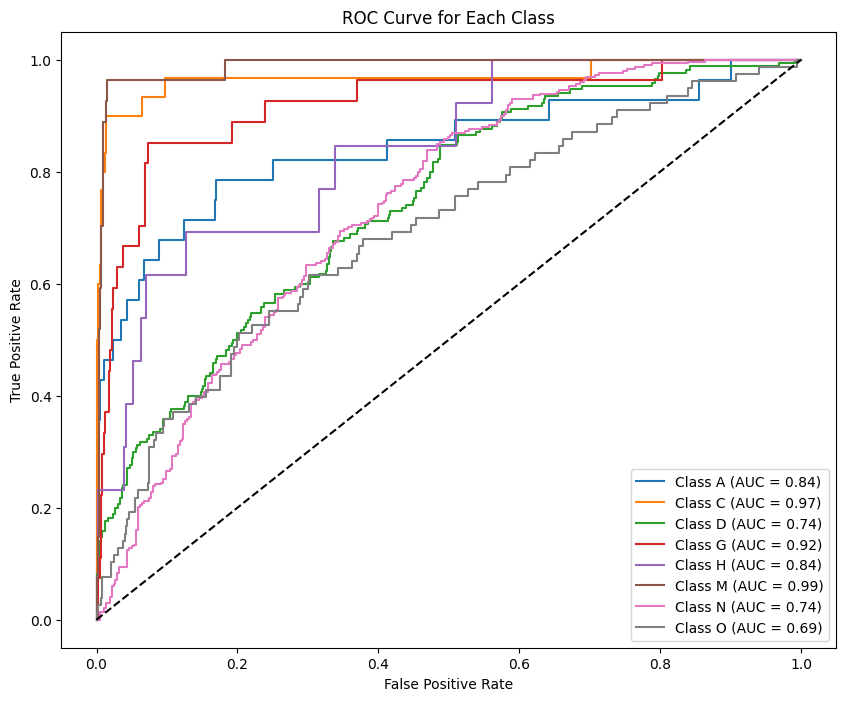

In [82]:
# Plot ROC Curve for each class
n_classes = len(label_encoder.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc[i] = roc_auc_score(all_labels == i, all_probs[:, i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()

In [83]:
conf_matrix = confusion_matrix(all_labels, all_preds)
print('\nConfusion Matrix:')
print(conf_matrix)


Confusion Matrix:
[[ 18   0   1   0   1   1   5   2]
 [  0  26   0   1   0   1   1   1]
 [  9   2  68   4   5   2  67  13]
 [  2   0   0  18   0   0   7   0]
 [  0   0   3   1   3   0   5   1]
 [  0   0   1   2   0  24   0   0]
 [ 13   4  42  29   8   3 183  16]
 [ 13   4  17   3   0   2  26  13]]


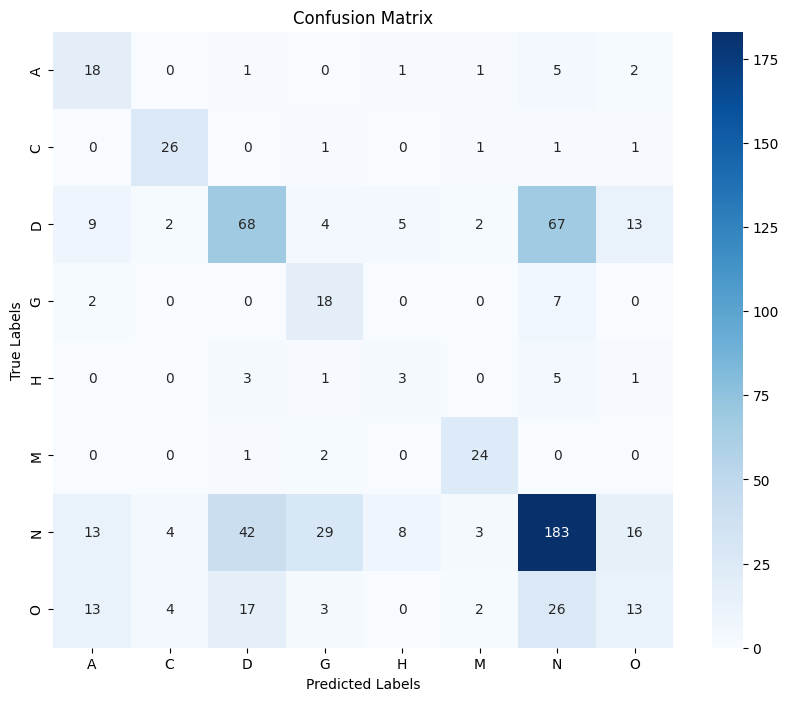

In [84]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

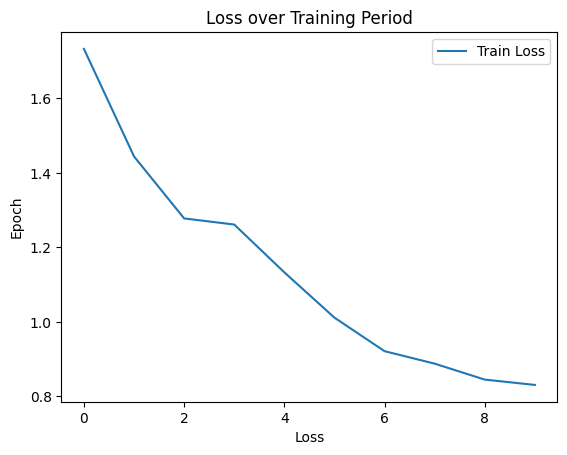

In [85]:
training_history_df.plot(y='Train Loss')
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.title('Loss over Training Period')
plt.show()

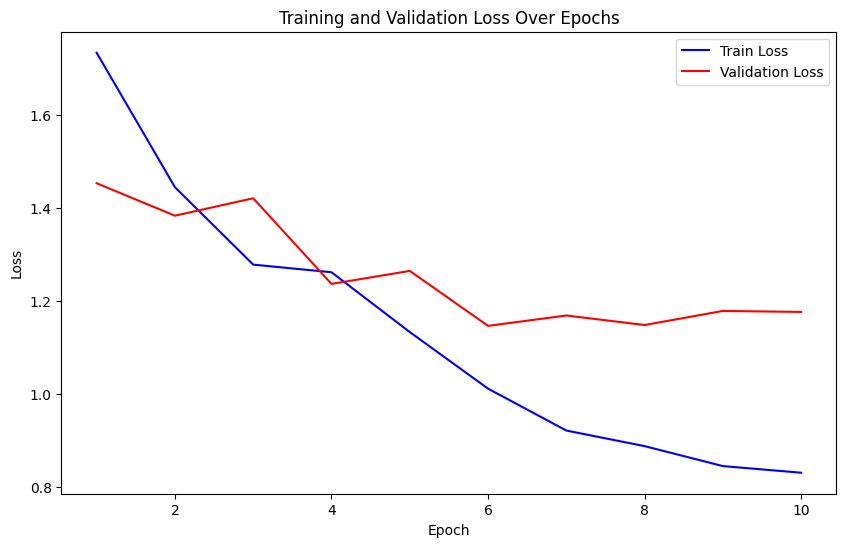

In [86]:
plt.figure(figsize=(10,6))

plt.plot(training_history_df['Epoch'], training_history_df['Train Loss'], label='Train Loss', color='blue')
plt.plot(training_history_df['Epoch'], training_history_df['Val Loss'], label='Validation Loss', color='red')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()